In [1]:
!pip install pytorch-msssim -q
!pip install umap -q
!pip install umap-learn -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.3 MB/s eta 0:00:00


# Overview
This notebook is my submission of the Image-based task i.e. second task for the project titled "Foundation Models for Exoplanet Characterization" by EXXA @ ML4SCI under GSoC'25

In this task we are required to come up with an autoencoder for best latent space representations of the ALMA dataset images, which are single channel images (since only 1st channel of the fits file was used). To achieve this task I will use 3 major approaches:


---


### 1. Masked Autoencoders
MAEs are very effecient for self-supervised pretraining tasks, since they have an asymmetric
encoder-decoder architecture, with an encoder that operates only on the visible subset of patches (without mask tokens), along with a lightweight decoder that reconstructs the original image from the latent representation and mask. Also masking a high ratio of visible patches provides better representations tokens.
For MAE I will use the implementation discussed in the following paper :

**He, K., Chen, X., Xie, S., Li, Y., Dollár, P., & Girshick, R. (2022).**  
*Masked autoencoders are scalable vision learners.*  
Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition, 16000–16009.  
[Paper Link](https://arxiv.org/abs/2111.06377)

---

### 2. Convolution Autoencoder
Convolutional layers can be really good for extracting local and global features from the image. In this approach I will convolution style encoder for extracting the image features and then mapping them to latent space with a feed-forward layer. Decoder will be symmetric to the encoder with upconv layers. In this for better learning I will also implement random masking but not patch based masking as implemented above. 
I also experimented with the ConMAE style architectures discussed [here](https://arxiv.org/abs/2205.03892) but I found there performance similar to MAE that I have implemented, hence I am not including them in this task, but I can definitely leverage their usage in the final project

---

### 3. Custom Autoencoder
I found that hand crafted features also perform very much better during clustering in the general task. Hence I will train a simple Neural network style autoencoder with MLP layers on top of the features extracted from the images, this features will be considered as input to the autoencoder instead of the complete image. Since these features cover most of the usefull information of the image, Latent space of this encoder will be very meaningful and provide good representation for this task

---

### 4. Hybrid loss
All the approaches discussed above use a hybrid of MSE and MS-SSIM loss during training which gives us better quantitative and qualitative results


#### NOTE : All the approached will be discussed later in this notebook as and when required


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from astropy.io import fits
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from tqdm.auto import tqdm
from glob import glob
import cv2, os
import umap
import umap.umap_ as umap
from scipy import ndimage
from skimage.feature import hog, local_binary_pattern
from skimage.measure import regionprops, moments
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from functools import partial
from timm.models.vision_transformer import PatchEmbed, Block
import torch.nn.functional as F
import torch.optim as optim
from pytorch_msssim import MS_SSIM, SSIM
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from tqdm.auto import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32
latent_dim = 384
folder_path = "./data/ALMA/"
print(f'Using {device.upper()}')

Using CUDA


# Masked Autoencoder (MAE)

This cell implements a **Masked Autoencoder (MAE) with a Vision Transformer (ViT) backbone** for self-supervised learning. The model is designed to reconstruct missing patches in images by encoding visible patches and decoding them back to the full image.

---

## **Workflow**

1. **Patch Embedding**:
   - The input image \( \mathbf{x} \) of size \( 224 \times 224 \) is divided into **non-overlapping patches** of size \( 16 \times 16 \).
   - Each patch is linearly projected into a **latent embedding space**.

2. **Random Masking**:
   - A fraction \( $\rho = 0.75$ \) of patches is randomly masked.
   - Only the remaining \( $(1 - \rho)$ \) fraction is passed through the encoder.

3. **Transformer-Based Encoding**:
   - The visible patch embeddings are processed through a **ViT encoder**, which consists of **multi-head self-attention (MSA) and feedforward layers**.
   - **Learnable class token** is prepended, and **fixed sinusoidal positional embeddings** are added.

4. **Decoder for Reconstruction**:
   - Masked tokens are reintroduced using a **learnable mask token**.
   - The sequence is processed through a shallow **Transformer decoder**.
   - The final **linear layer predicts pixel values for each masked patch**.

5. **Loss Function**:
   - **Mean Squared Error (MSE):** Measures pixel-wise reconstruction loss.
   - **Multi-Scale Structural Similarity (MS-SSIM):** Captures perceptual differences in structure.
   - **Final Loss:** 
     $$ \mathcal{L} = \mathcal{L}_{\text{MSE}} + (1 - \text{MS-SSIM}) $$

---

## **Key Features**
- **Masked Image Modeling (MIM):** Learns meaningful representations by predicting missing content.
- **ViT-Based Encoder:** Utilizes **self-attention** for contextual feature extraction.
- **Efficient Decoding:** Reconstructs only **masked patches**, reducing computational cost.
- **Hybrid Loss Function:** Ensures both pixel fidelity and perceptual quality.

---

## Summary

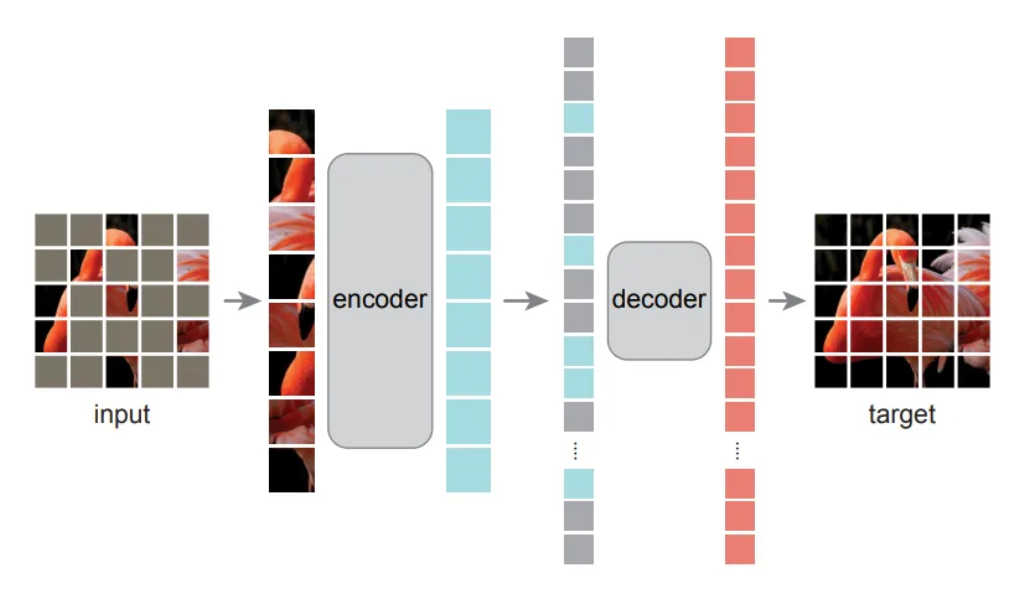

This image was taken from the research paper [Masked autoencoders are scalable vision learners](https://arxiv.org/abs/2111.06377)


In [3]:
# Positional embedding functions
def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token:
        pos_embed = np.concatenate([np.zeros([1, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


def interpolate_pos_embed(model, checkpoint_model):
    if 'pos_embed' in checkpoint_model:
        pos_embed_checkpoint = checkpoint_model['pos_embed']
        embedding_size = pos_embed_checkpoint.shape[-1]
        num_patches = model.patch_embed.num_patches
        num_extra_tokens = model.pos_embed.shape[-2] - num_patches
        # height (== width) for the checkpoint position embedding
        orig_size = int((pos_embed_checkpoint.shape[-2] - num_extra_tokens) ** 0.5)
        # height (== width) for the new position embedding
        new_size = int(num_patches ** 0.5)
        # class_token and dist_token are kept unchanged
        if orig_size != new_size:
            print("Position interpolate from %dx%d to %dx%d" % (orig_size, orig_size, new_size, new_size))
            extra_tokens = pos_embed_checkpoint[:, :num_extra_tokens]
            # only the position tokens are interpolated
            pos_tokens = pos_embed_checkpoint[:, num_extra_tokens:]
            pos_tokens = pos_tokens.reshape(-1, orig_size, orig_size, embedding_size).permute(0, 3, 1, 2)
            pos_tokens = torch.nn.functional.interpolate(
                pos_tokens, size=(new_size, new_size), mode='bicubic', align_corners=False)
            pos_tokens = pos_tokens.permute(0, 2, 3, 1).flatten(1, 2)
            new_pos_embed = torch.cat((extra_tokens, pos_tokens), dim=1)
            checkpoint_model['pos_embed'] = new_pos_embed

In [4]:
# Model architecture modified for single channel images and hybrid loss
class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=1,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        self.msssim = MS_SSIM(data_range=1.0, win_size=3, channel=1)
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 1, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 1))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 1))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 1, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        # sort noise for each sample
        ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5
        
        mse_loss = (pred - target) ** 2
        mse_loss = mse_loss.mean(dim=-1)  # [N, L], mean loss per patch

        mse_loss = (mse_loss * mask).sum() / mask.sum()  # mean loss on removed patches
        pred_4d = pred.unsqueeze(1)
        target_4d = target.unsqueeze(1)
        ssim_loss = self.msssim(pred_4d, target_4d)
        return mse_loss, ssim_loss

    def forward(self, imgs, mask_ratio=0.75):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio)
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        mse_loss, ssim_loss = self.forward_loss(imgs, pred, mask)
        return mse_loss, ssim_loss, pred, mask

# function to initialize moodel
def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model

# Convolutional Masked Autoencoder 

This cell implements a **Convolutional Masked Autoencoder (Conv MAE)** for image reconstruction. The workflow involves encoding partially masked images into a latent space and then decoding them to reconstruct the original image.

---

## Model Architecture

### Encoder
- **Convolutional Feature Extraction:**  
  The encoder is built using 5 convolutional blocks that progressively downsample the input image. The progression is as follows:
  - **Input:** 1 channel  
  - **Conv Layers:** 1 → 32 → 64 → 128 → 256 → 512 channels  
  - **Operations:** Each convolution is followed by Batch Normalization and ReLU activation.
- **Latent Projection:**  
  After the convolutional layers, the feature maps are flattened and projected into a latent space using a fully connected layer:
  $$ \mathbf{z} = f_{\text{enc}}(\mathbf{x}) \in \mathbb{R}^{384} $$
  where \(384\) is the default latent dimension.

### Decoder
- **Latent Expansion:**  
  The latent vector is first mapped back to a high-dimensional tensor:
  $$ \text{reshape}( \mathbf{z} ) \rightarrow [512, 7, 7] $$
- **Transpose Convolutions:**  
  The decoder consists of transpose convolution layers that upsample the feature maps:
  - **Upsampling:** 512 → 256 → 128 → 64 → 32 → 1 channel  
  - **Activation:** Each layer (except the final) uses Batch Normalization and ReLU. The final layer uses a Sigmoid activation to ensure outputs are in \([0, 1]\).

---

## Workflow

1. **Random Masking:**
   - **Objective:** Simulate missing information by randomly zeroing out pixels.
   - **Mechanism:** For an input image \( $\mathbf{x}$ \) of shape $([B, C, H, W])$, a mask is generated where each pixel is dropped (set to 0) with probability \( $\rho = 0.75$ \).

2. **Encoding & Decoding:**
   - **Encoding:** The masked image is passed through the encoder to obtain the latent representation \( $\mathbf{z}$ \).
   - **Decoding:** The latent vector is then decoded to reconstruct the image:
     $$ \hat{\mathbf{x}} = f_{\text{dec}}(\mathbf{z}) $$

3. **Hybrid Loss Function:**
   - **Mean Squared Error (MSE)**
   - **Multi-Scale Structural Similarity (MS-SSIM):**
     A perceptual loss that captures structural similarity between the original and reconstructed images.
   - **Combined Loss:**
     The overall loss combines both losses:
     $$ \mathcal{L} = \text{MSE}(\mathbf{x}, \hat{\mathbf{x}}) + \left(1 - \text{MS-SSIM}(\mathbf{x}, \hat{\mathbf{x}})\right) $$

4. **Utility Functions:**
   - **encode:** Extracts the latent representation from an image.
   - **decode:** Reconstructs the image from a latent vector.

---

## Summary

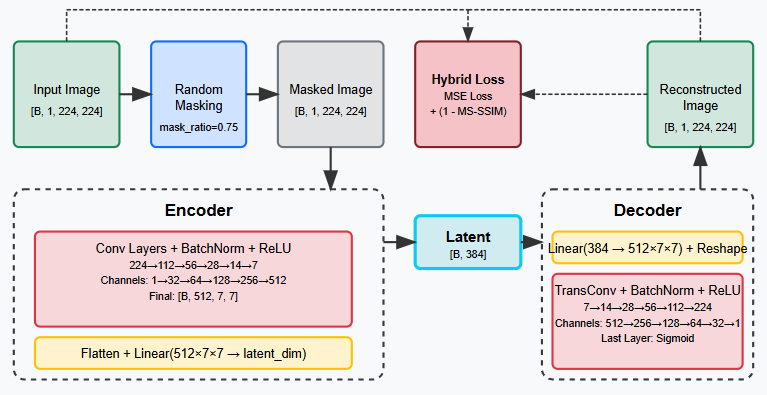


In [5]:
# defining encoder - decoder architectures
class Encoder(nn.Module):
    def __init__(self, latent_dim=384):
        super(Encoder, self).__init__()
        
        # Convolutional layers for feature extraction
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # 112x112
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # 56x56
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 28x28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 14x14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 7x7
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        
        # Flatten and project to latent space
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512 * 7 * 7, latent_dim)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, latent_dim=384):
        super(Decoder, self).__init__()
        
        # Project from latent space and reshape
        self.fc = nn.Linear(latent_dim, 512 * 7 * 7)
        
        # Transpose convolutions for upsampling
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14x14
            nn.BatchNorm2d(256),
            nn.ReLU(),
            
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28x28
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 56x56
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 112x112
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 224x224
            nn.Sigmoid()  # Output normalized between 0 and 1
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 512, 7, 7)
        x = self.decoder(x)
        return x

In [6]:
# Model with hybrid loss
class ConvMaskedAutoencoder(nn.Module):
    def __init__(self, latent_dim=384, mask_ratio=0.75):
        super(ConvMaskedAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)
        self.mask_ratio = mask_ratio
        self.latent_dim = latent_dim
        
    def random_masking(self, x):
        """
        Perform per-sample random masking by replacing with zeros.
        x: [B, C, H, W], batch of images
        """
        # Create patches (we'll simulate this by just masking random pixels)
        B, C, H, W = x.shape
        
        # Create a mask (1 = keep, 0 = remove)
        mask = torch.ones((B, C, H, W), device=x.device)
        mask_indices = torch.rand((B, C, H, W), device=x.device) < self.mask_ratio
        mask[mask_indices] = 0
        
        # Apply mask
        masked_x = x * mask
        
        return masked_x, mask
    
    def forward(self, x):
        # Apply random masking
        masked_x, mask = self.random_masking(x)
        
        # Encode the masked image
        latent = self.encoder(masked_x)
        
        # Decode back to image space
        reconstructed = self.decoder(latent)
        
        return reconstructed, latent
    
    def encode(self, x):
        """Method to access the latent representation"""
        return self.encoder(x)
    
    def decode(self, z):
        """Method to decode from latent space"""
        return self.decoder(z)

class HybridLoss(nn.Module):
    def __init__(self, data_type='images'):
        super(HybridLoss, self).__init__()
        self.mse = nn.MSELoss()
        if (data_type=='images'):
            self.ms_ssim = MS_SSIM(data_range=1.0, win_size=3, channel=1)
        else:
            self.ms_ssim = MS_SSIM(data_range=1.0, win_size=1, channel=1)
            
    
    def forward(self, x, y):
        mse_loss = self.mse(x, y)
        
        if len(x.shape) == 2:
            x_4d = x.view(-1, 1, 2, x.shape[-1])   # reshaping to [bs, 1, 2, feats_dim]
            y_4d = y.view(-1, 1, 2, y.shape[-1])
        else:
            x_4d, y_4d = x, y
            
        ssim_value = self.ms_ssim(x_4d, y_4d)
        loss = mse_loss + (1 - ssim_value)
        return loss, mse_loss, ssim_value

# Custom Feature Extraction Autoencoder
Here we will define feature extraction pipeline and a simple MLP autoencoder

---

## **Feature Extraction**
1. **Basic Statistical Features**: Mean, standard deviation, median, interquartile range (IQR), maximum intensity, total flux, and center of mass.
2. **Radial Features**: Mass, density, and anisotropy at different radii from the center.
3. **Elliptic Features**: Mass, density, and anisotropy computed using elliptical regions of varying sizes.
4. **Radial Profiles at Angles**: Intensity profiles sampled at 0°, 45°, 90°, and 135°.
5. **Ring Features**: Intensity statistics along circular rings.
6. **Azimuthal Symmetry**: Measures asymmetry and variance within azimuthal segments.
7. **Image Moments**: Hu moments and region properties (area, eccentricity, axis lengths, etc.).
8. **Power Spectrum Analysis**: Radial distribution of frequency components from the 2D Fourier transform.

---

## Autoencoder

A **fully connected autoencoder** for dimensionality reduction and feature extraction. The model encodes high-dimensional inputs into a compact latent representation and reconstructs them back.


## **Workflow**

1. **Encoding**:
   - The input \( $\mathbf{x} \in \mathbb{R}^{d}$ \) is mapped to a **latent representation** \( $\mathbf{z}$ \) through a stack of fully connected layers:
     $$ \mathbf{z} = f_{\text{enc}}(\mathbf{x}) \in \mathbb{R}^{384} $$  
   - Batch Normalization and ReLU activations ensure stable training and non-linearity.

2. **Decoding**:
   - The latent representation is mapped back to the input space using another fully connected network:
     $$ \hat{\mathbf{x}} = f_{\text{dec}}(\mathbf{z}) $$  
   - The output dimension matches the input, ensuring end-to-end reconstruction.


3. **Hybrid Loss Function:**
   - **Mean Squared Error (MSE)**
   - **Multi-Scale Structural Similarity (MS-SSIM):**
     A perceptual loss that captures structural similarity between the original and reconstructed images.
   - **Combined Loss:**
     The overall loss combines both losses:
     $$ \mathcal{L} = \text{MSE}(\mathbf{x}, \hat{\mathbf{x}}) + \left(1 - \text{MS-SSIM}(\mathbf{x}, \hat{\mathbf{x}})\right) $$

---

## **Key Features**
- **Highly enrich features** as input
- **Fully Connected Architecture:** Suitable for **tabular or feature-based datasets**.
- **Latent Space Representation:** Compressed encoding allows for **feature extraction and clustering**.



In [7]:
class FeatureExtractor:
    def __init__(self, img_paths, transform, apply_clipping=True):
        self.img_paths = img_paths
        self.apply_clipping = apply_clipping
        self.transform = transform
        self.image_feats = None
        self.reduced_feats = None
        self.cluster_labels = None

    #defining some helper functions

    def circle_perimeter(self, cy, cx, radius, shape):
        """
        Create circle perimeter coordinates safely within image bounds
        """
        # Create a meshgrid of coordinates
        y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
        
        # Calculate distance from center
        dist = np.sqrt(x*x + y*y)
        
        # Find indices close to the desired radius
        mask = np.abs(dist - radius) < 0.5
        
        # Get coordinates
        cy_indices, cx_indices = np.where(mask)
        
        # Adjust to center position and ensure within bounds
        cy_indices = np.clip(cy_indices + cy - radius, 0, shape[0]-1)
        cx_indices = np.clip(cx_indices + cx - radius, 0, shape[1]-1)
        
        return cy_indices, cx_indices
    
    def calculate_moments(self, image):
        """
        Calculate image moments for feature extraction
        """
        image = image.squeeze().detach().cpu().numpy()
        # Calculate Hu moments
        props = regionprops(np.uint8(image > np.mean(image)))[0]
        
        # Get moment features
        moments_features = [
            props.area,
            props.eccentricity,
            props.major_axis_length,
            props.minor_axis_length,
            props.orientation,
            props.perimeter,
            props.solidity
        ]
        
        return moments_features
    
    def calculate_power_spectrum(self, image):
        """
        Calculate radially averaged power spectrum
        """
        # Compute 2D FFT
        image = image.squeeze().detach().cpu().numpy()
        image_fft = np.fft.fftshift(np.fft.fft2(image))
        power_spectrum = np.abs(image_fft)**2
        
        # Get center coordinates
        center_y, center_x = image.shape[0] // 2, image.shape[1] // 2
        
        # Create radial bins
        max_radius = min(center_y, center_x) - 1
        num_bins = 20
        bin_edges = np.linspace(0, max_radius, num_bins + 1)
        
        # Calculate radial profile
        radial_profile = []
        for i in range(num_bins):
            r_min, r_max = bin_edges[i], bin_edges[i+1]
            
            # Create a mask for this radial bin
            y, x = np.ogrid[-center_y:image.shape[0]-center_y, -center_x:image.shape[1]-center_x]
            r = np.sqrt(x*x + y*y)
            mask = (r >= r_min) & (r < r_max)
            
            # Calculate mean power in this bin
            if np.sum(mask) > 0:
                radial_profile.append(np.mean(power_spectrum[mask]))
            else:
                radial_profile.append(0)
        
        return radial_profile

    def get_img(self, idx):
        img_data = fits.getdata(self.img_paths[idx])[0]
        img_data = img_data.squeeze()
        img_data = img_data.astype(np.float32, copy=True)
        if (self.apply_clipping):
            lower_percentile = np.percentile(img_data, 1)  # 1st percentile
            upper_percentile = np.percentile(img_data, 99)  # 99th percentile
            img_data = np.clip(img_data, lower_percentile, upper_percentile)
        img_data = self.transform(image=img_data)
        return img_data['image']

    # define functions for feature extractions
    
    def basic_feats(self, image):
        image = image.squeeze().detach().cpu().numpy()
        feature_vector = []
        feature_vector.extend([
                np.mean(image),  # Mean intensity
                np.std(image),   # Standard deviation
                np.median(image), # Median
                np.percentile(image, 75) - np.percentile(image, 25),  # IQR
                np.max(image),   # Max intensity
                np.sum(image),   # Total flux
                ndimage.measurements.center_of_mass(image)[0],  # Center of mass Y
                ndimage.measurements.center_of_mass(image)[1],  # Center of mass X
            ])
        return feature_vector
            
    def get_radial_feats(self, image, dr=2):  # img_shape -> (1, 224, 224)
        img_np = image.squeeze().detach().cpu().numpy()
        cx, cy = 112, 112
        h, w = img_np.shape
        y_indices, x_indices = np.indices((h, w))
        r_array = np.sqrt((x_indices - cx)**2 + (y_indices - cy)**2)
        theta_array = np.arctan2(y_indices - cy, x_indices - cx)
        r_max = 112  # max radius (half the image size)
        r_values = np.arange(0, r_max, dr)
        radial_mass = []
        radial_density = []
        radial_grad = []
        
        for r in r_values:
            # Create annulus mask
            annulus_mask = (r_array >= r) & (r_array < r + dr)
            mass = img_np[annulus_mask].sum()
            radial_mass.append(mass)
            
            # Compute annulus area
            annulus_area = np.pi * ((r + dr)**2 - r**2)
            density = mass / annulus_area if annulus_area > 0 else 0
            radial_density.append(density)
            
            # Compute mass gradient (anisotropy) along the annulus
            # Use the pixel angles within the annulus.
            annulus_masses = img_np[annulus_mask]
            annulus_angles = theta_array[annulus_mask]
            if mass > 0:
                X = np.sum(annulus_masses * np.cos(annulus_angles))
                Y = np.sum(annulus_masses * np.sin(annulus_angles))
                grad = np.sqrt(X**2 + Y**2) / mass
            else:
                grad = 0
            radial_grad.append(grad)
        
        # Normalize radial features (if desired)
        radial_mass = np.array(radial_mass)
        radial_mass_norm = (radial_mass - radial_mass.min()) / (radial_mass.max() - radial_mass.min() + 1e-8)
        
        radial_density = np.array(radial_density)
        radial_density_norm = (radial_density - radial_density.min()) / (radial_density.max() - radial_density.min() + 1e-8)
        
        radial_grad = np.array(radial_grad)
        radial_grad_norm = (radial_grad - radial_grad.min()) / (radial_grad.max() - radial_grad.min() + 1e-8)

        radial_feats = np.concatenate([radial_mass_norm,
                                       radial_density_norm,
                                       radial_grad_norm])
        return radial_feats
        
    def get_elliptic_feats(self, image): # img_shape -> (1, 224, 224)
        img_np = image.squeeze().detach().cpu().numpy()
        cx, cy = 112, 112
        h, w = img_np.shape
        y_indices, x_indices = np.indices((h, w))
        a_values = np.linspace(1, 100, 10)
        b_values = np.linspace(1, 100, 10)
        
        elliptical_mass = []
        elliptical_density = []
        elliptical_grad = []
        for a in a_values:
            for b in b_values:
                # Elliptical mask: standard ellipse equation centered at (cx,cy)
                ellipse_mask = (((x_indices - cx)**2) / (a**2) + ((y_indices - cy)**2) / (b**2)) <= 1
                mass = img_np[ellipse_mask].sum()
                elliptical_mass.append(mass)
                
                # Ellipse area = π * a * b
                ellipse_area = np.pi * a * b
                density = mass / ellipse_area if ellipse_area > 0 else 0
                elliptical_density.append(density)
                
                # Compute elliptical gradient.
                # For the elliptical region, first normalize coordinates so the ellipse becomes a unit circle.
                # Then compute the angular distribution.
                if mass > 0:
                    x_norm = (x_indices[ellipse_mask] - cx) / a
                    y_norm = (y_indices[ellipse_mask] - cy) / b
                    angles = np.arctan2(y_norm, x_norm)
                    masses = img_np[ellipse_mask]
                    X = np.sum(masses * np.cos(angles))
                    Y = np.sum(masses * np.sin(angles))
                    grad = np.sqrt(X**2 + Y**2) / mass
                else:
                    grad = 0
                elliptical_grad.append(grad)
        
        # Convert to arrays and normalize elliptical features
        elliptical_mass = np.array(elliptical_mass)
        elliptical_mass_norm = (elliptical_mass - elliptical_mass.min()) / (elliptical_mass.max() - elliptical_mass.min() + 1e-8)
        
        elliptical_density = np.array(elliptical_density)
        elliptical_density_norm = (elliptical_density - elliptical_density.min()) / (elliptical_density.max() - elliptical_density.min() + 1e-8)
        
        elliptical_grad = np.array(elliptical_grad)
        elliptical_grad_norm = (elliptical_grad - elliptical_grad.min()) / (elliptical_grad.max() - elliptical_grad.min() + 1e-8)

        elliptic_feats = np.concatenate([
            elliptical_mass_norm,
            elliptical_density_norm,
            elliptical_grad_norm
        ])
        return elliptic_feats

    def get_radial_profiles_at_angles(self, image):
        feature_vector = []
        image = image.squeeze().detach().cpu().numpy()
        cx, cy = 112, 112
        for angle in [0, 45, 90, 135]:
            angle_rad = np.deg2rad(angle)
            profile = []
            for r in range(0, 112, 10):  # Sample every 10 pixels up to 300 pixels from center
                y = int(cy + r * np.sin(angle_rad))
                x = int(cx + r * np.cos(angle_rad))
                
                # Check bounds
                if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]:
                    profile.append(image[y, x])
                else:
                    profile.append(0)
            
            # Add profile statistics to feature vector
            feature_vector.extend([
                np.mean(profile),
                np.std(profile),
                np.max(profile),
                np.sum(profile)
            ])
        return feature_vector

    def ring_features(self, image):
        image = image.squeeze().detach().cpu().numpy()
        cx, cy = 112, 112
        feature_vector = []
        rings = []
        for r in range(20, 112, 10):  # Sample rings at different radii
            y_indices, x_indices = self.circle_perimeter(cy, cx, r, shape=image.shape)
            ring_values = image[y_indices, x_indices]
            
            rings.append(np.mean(ring_values))
            rings.append(np.std(ring_values))
            
        # Add ring features
        feature_vector.extend(rings)
        return feature_vector

    def azimuthal_symmetry_feats(self, image):
        image = image.squeeze().detach().cpu().numpy()
        cx, cy = 112, 112
        azimuthal_features = []
        for r in range(5, 112, 10):  # Check a few key radii
            # Get coordinates of points on the circle
            y_indices, x_indices = self.circle_perimeter(cy, cx, r, shape=image.shape)
            ring_values = image[y_indices, x_indices]
            
            # Measure asymmetry (ratio of max/min)
            if np.min(ring_values) > 0:
                asymmetry = np.max(ring_values) / np.min(ring_values)
            else:
                asymmetry = 1.0
                
            azimuthal_features.append(asymmetry)
            
            # Also check for specific asymmetries (potential planet signatures)
            # Divide the ring into 8 segments and look at variance
            segments = np.array_split(ring_values, 8)
            segment_means = [np.mean(seg) for seg in segments]
            azimuthal_features.append(np.var(segment_means))
        return azimuthal_features

    def extract_feats(self):
        self.image_feats = []
        for i in range(len(self.img_paths)):
            feature_vector = []
            image = self.get_img(i);
            feature_vector.extend(self.basic_feats(image))
            feature_vector.extend(self.get_radial_feats(image))
            feature_vector.extend(self.get_elliptic_feats(image))
            feature_vector.extend(self.get_radial_profiles_at_angles(image))
            feature_vector.extend(self.ring_features(image))
            feature_vector.extend(self.azimuthal_symmetry_feats(image))
            feature_vector.extend(self.calculate_moments(image))
            feature_vector.extend(self.calculate_power_spectrum(image))

            self.image_feats.append(feature_vector)

            if ((i+1)%10 == 0):
                print(f"Extracted features for {i+1} image..")
        self.image_feats = np.array(self.image_feats)
        scaler = StandardScaler()
        self.image_feats = scaler.fit_transform(self.image_feats)
        return self.image_feats
        
class CustomAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=384):
        super(CustomAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

# Training utility functions
This function trains and evaluates a model over multiple epochs, utilizing various optimizers, learning rate schedulers, and loss functions.

### **Parameters:**
- `model`: PyTorch model to be trained.
- `train_loader`, `test_loader`: Data loaders for training and testing datasets.
- `save_dir`: Path to save the best model.
- `epochs` *(default=30)*: Number of training epochs.
- `lr` *(default=1.5e-4)*: Learning rate.
- `optimizer` *(default='adam')*: Choice of optimizer (`adam`, `adamw`, `radam`, `sgd`, `rmsprop`).
- `scheduler` *(default=None)*: Learning rate scheduler (`ReduceLROnPlateau`, `CosineAnnealingLR`, `ExponentialLR`).
- `weight_decay` *(default=0.01)*: Regularization parameter.
- `criterion` *(default=None)*: Loss function, supports custom `HybridLoss`.
- `data_type` *(default='images')*: Type of input data.

### **Training Process:**
1. **Optimizer Setup**:  
2. **Scheduler Selection**: Adjusts learning rate \( $\alpha$ \) dynamically.
3. **Loss Function**:  
   - Uses MS-SSIM and MSE both for evaluation:
     
     $\text{Total Loss} = (1 - \text{MS-SSIM}) + \text{MSE}$
     
4. **Training Loop**:
   - Computes training loss using `train_fn`: \( $\mathcal{L}_{\text{train}}$ \)
   - Evaluates on test data using `test_fn`:  
     - Mean Squared Error (MSE):  
     - Multi-Scale Structural Similarity (MS-SSIM).
   - Updates best model if performance improves.

### **Outputs:**
- Returns best MS-SSIM, best MSE, and model save path.

In [8]:
def train_fn(model, train_loader, optimizer, device, criterion=None):
    model.train().to(device)
    it_loss = 0
    counter = 0
    for i, data in enumerate(tqdm(train_loader,total = len(train_loader))):
        imgs = data['img_data'].to(device)
        optimizer.zero_grad()
        
        if (criterion is None):
            mse_loss, ssim_loss, _, _ = model(imgs)
            loss = mse_loss + (1 - ssim_loss)
        else:
            reconstructed, _ = model(imgs)
            loss, _, _ = criterion(reconstructed, imgs)
            
        loss.backward()
        optimizer.step()
        it_loss += loss.item() * imgs.shape[0]
        counter += imgs.shape[0]
    return it_loss/counter

def test_fn(model, test_loader, device, criterion=None):
    model.eval().to(device)
    it_mse = 0
    it_ssim = 0
    counter = 0
    for i, data in enumerate(tqdm(test_loader,total = len(test_loader))):
        imgs = data['img_data'].to(device)
        with torch.no_grad():
            if (criterion is None):
                mse_loss, ssim_loss, _, _ = model(imgs)
            else:
                reconstructed, _ = model(imgs)
                _, mse_loss, ssim_loss = criterion(reconstructed, imgs)
                
            it_mse += mse_loss.item() * imgs.shape[0]
            it_ssim += ssim_loss.item() * imgs.shape[0]
            counter += imgs.shape[0]
    return it_ssim/counter, it_mse/counter

def run_epochs(model, train_loader, test_loader, save_dir, 
               epochs=30, lr=1.5e-4, optimizer='adam', scheduler=None, 
               weight_decay=0.01, criterion=None, data_type='images'):
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if (optimizer == 'adam'):
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif (optimizer == 'adamw'):
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif (optimizer == 'radam'):
        optimizer = optim.RAdam(model.parameters(), lr=lr, weight_decay = weight_decay)
    elif (optimizer == 'sgd'):
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay = weight_decay)
    elif (optimizer == 'rmsprop'):
        optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay = weight_decay)
    else:
        print("Unknown optimzer, pass optimizer object instead for this")
        return 

    
    if (scheduler.lower() == 'reducelronplateau'):
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)
    elif (scheduler.lower() == 'cosineannealinglr'):
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = epochs)
    elif (scheduler.lower() == 'exponentiallr'):
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    else:
        print("Unknown scheduler, pass scheduler object instead for this")
        return 

    if (criterion is not None and criterion.lower() == 'hybridloss'):
        criterion = HybridLoss(data_type)

    best_loss = float('inf')
    best_ssim = 0.0
    best_mse = float('inf')
    for epoch in range(epochs):
        train_loss = train_fn(model, train_loader, optimizer, device, criterion)
        test_ssim, test_mse = test_fn(model, test_loader, device, criterion)
        total_loss = (1 - test_ssim) + test_mse
        if (scheduler is not None):
            scheduler.step(total_loss)

        if (total_loss < best_loss):
            best_loss = total_loss
            best_ssim = test_ssim
            best_mse = test_mse
            torch.save({
                'model_dict':model.state_dict(),
                'optimizer_dict':optimizer.state_dict()
            }, save_dir)

            print('MODEL SAVED!')
        print(f'Epoch {epoch+1}, Train loss: {train_loss:.6f}, Test MSE : {test_mse:.6f}, Test MS-SSIM : {test_ssim:.6f}')
    return best_ssim, best_mse, save_dir
        

# Image Augmentations
The augmentations and dataset class used are same as the of general task 

---


### **1. Image Transformations (ViT-Compatible)**
The `transform_vit` pipeline uses the **Albumentations** library for preprocessing images into a format suitable for ViTs. The key steps include:

- **Normalization:**  
  
  $I' = \frac{I - \mu}{\sigma}$

  
  where mean \($\mu$ = 0\) and standard deviation \($\sigma$ = 1\) after transformation.
  
- **Resizing & Padding:**  
  - Scales images to a max size of 256 pixels.
  - Pads smaller images to \(256 $\times$ 256\) using a constant black border.
  - Resizes all images to \(224 $\times$ 224\) for uniformity.
  
- **Conversion to Tensor:**  
  - Ensures compatibility with PyTorch models.
 
### **2. Image Transformations (For feature extractions)**
the `transform_for_feature_extraction` pipeline is same above pipeline except for the normalizations, since extracting features before normalization provides better insights. We will scale the extracted features using `StandardScaler()` in the model class

---

### **3. FITSDataset Class**
The `FITSDataset` class is a PyTorch `Dataset` that:
- Loads **FITS images** using `astropy.fits`.
- Applies **clipping** to remove extreme values (1st–99th percentile). Mathematically described as:
   $ I_{\text{clipped}} = \min(\max(I, P_1), P_{99}) $
- Supports **optional augmentations** and **channel expansion** (e.g., for CNNs expecting RGB).

Each sample returns:

$\text{{img\_data}} \in \mathbb{R}^{1 \times 224 \times 224} \text{ (or } 3 \times 224 \times 224 \text{ if expanded)}$

### **4. SimpleDataset Class**
A simple dataset class used for hand-crafted features extracted from the image 


In [9]:
transform_mae = A.Compose(
    [
        A.Normalize(
            mean=0, 
            std=1, 
            max_pixel_value=1.0,  # Adjust based on your image values
            always_apply=True,
        ),
        A.LongestMaxSize(max_size=256, always_apply=True),
        A.PadIfNeeded(
            min_height=256, 
            min_width=256, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            always_apply=True
        ),
        A.Resize(
            height=224,
            width=224,
            always_apply=True
        ),
        ToTensorV2(always_apply=True),
    ]
)

transform_cae = A.Compose(
    [
        A.LongestMaxSize(max_size=256, always_apply=True),
        A.PadIfNeeded(
            min_height=256, 
            min_width=256, 
            border_mode=cv2.BORDER_CONSTANT, 
            value=0, 
            always_apply=True
        ),

        A.Resize(
            height=224,
            width=224,
            always_apply=True
        ),
        ToTensorV2(always_apply=True),
    ]
)

class FITSDataset(Dataset):
    def __init__(self, fits_paths, transform = None,
                 apply_clipping=True, expand_channels=False):
        self.paths = fits_paths
        self.apply_clipping = apply_clipping
        self.expand_channels=expand_channels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_data = fits.getdata(self.paths[idx])[0]
        img_data = img_data.squeeze()
        img_data = img_data.astype(np.float32, copy=True)
        
        if (self.apply_clipping):
            lower_percentile = np.percentile(img_data, 1)  # 1st percentile
            upper_percentile = np.percentile(img_data, 99)  # 99th percentile
            img_data = np.clip(img_data, lower_percentile, upper_percentile)
        
        if self.transform is not None:
            img_data = self.transform(image=img_data)
            if (self.expand_channels):
                img_data['image'] = img_data['image'].repeat(3, 1, 1)
            return {
                'img_data': img_data['image'],
                'img_path': self.paths[idx]
            }
        else:
            return {
                'img_data': img_data
            }

class SimpleDataset(Dataset):
    def __init__(self, extracted_feats, image_paths, transform = transform_cae):
        self.extracted_feats = extracted_feats
        self.image_paths = image_paths
    def __len__(self):
        return extracted_feats.shape[0]
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        img = fits.getdata(image_path)[0]
        img = img.squeeze()
        img = img.astype(np.float32, copy=True)
        lower_percentile = np.percentile(img, 1)  # 1st percentile
        upper_percentile = np.percentile(img, 99)  # 99th percentile
        img = np.clip(img, lower_percentile, upper_percentile)
        
        #print(img.dtype)
        return {
            'img_data':self.extracted_feats[idx],
            'img_path':image_path,
            'plot_img':img
        }


# Initializing Assets

Here I am initializing dataset classes and dataloader for training and extracting features as mentioned above

In [10]:
image_paths = sorted(glob(os.path.join(folder_path, "*.fits")))
image_modelling_dataset = FITSDataset(image_paths, transform = transform_mae)

extractor = FeatureExtractor(image_paths, transform = transform_cae)
extracted_feats = extractor.extract_feats()
extracted_feats = torch.tensor(extracted_feats, dtype=torch.float32)

custom_feature_dataset = SimpleDataset(extracted_feats, image_paths)

train_ratio = 0.8
train_size = int(train_ratio * len(image_modelling_dataset))
test_size = len(image_modelling_dataset) - train_size
feats_dim = custom_feature_dataset[0]['img_data'].shape[0]

train_mae_dataset, test_mae_dataset = random_split(image_modelling_dataset,
                                                  [train_size, test_size])
train_cae_dataset, test_cae_dataset = random_split(custom_feature_dataset,
                                                  [train_size, test_size])

train_mae_loader = DataLoader(train_mae_dataset, batch_size = batch_size,
                             shuffle=True)
test_mae_loader = DataLoader(test_mae_dataset, batch_size = batch_size, 
                            shuffle = False)
train_cae_loader = DataLoader(train_cae_dataset, batch_size = batch_size*2,
                             shuffle = True)
test_cae_loader = DataLoader(test_cae_dataset, batch_size = batch_size*2, 
                            shuffle = False)

Extracted features for 10 image..
Extracted features for 20 image..
Extracted features for 30 image..
Extracted features for 40 image..
Extracted features for 50 image..
Extracted features for 60 image..
Extracted features for 70 image..
Extracted features for 80 image..
Extracted features for 90 image..
Extracted features for 100 image..
Extracted features for 110 image..
Extracted features for 120 image..
Extracted features for 130 image..
Extracted features for 140 image..
Extracted features for 150 image..


# Training models

### 1. MAE (Transformer based)
Training the MAE (ViT based) model 
#### Hyperparameter:
- epochs = $50$
- learning rate ($\alpha$) = $1.5 \times 10^{-4}$
- optimizer used is `Adam`
- scheduler is `ReduceLROnPlateau`
- L2 regularization with weight decay of $0.01$
- loss function is hybrid loss implemented in the model class

#### Results:
**MSE : $0.00076$** <br>
**MS-SSIM : $0.93238$**

In [11]:
model = mae_vit_base_patch16_dec512d8b()
save_dir = "./models/MAE_ViT_best.pth"

#criterion is none since it is implemented in model class

best_ssim, best_mse, _ = run_epochs(model, train_mae_loader, test_mae_loader, save_dir, 
           epochs=50, lr=1.5e-4, optimizer='adam', 
           scheduler='ReduceLROnPlateau', 
           weight_decay=0.01, criterion=None, data_type='images')   

print(f"\n\nRESULTS OF MAE (Transformer based)\nMS_SSIM : {best_ssim}\nMSE : {best_mse}")


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 1, Train loss: 1.751914, Test MSE : 0.159893, Test MS-SSIM : 0.051005


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 2, Train loss: 1.050784, Test MSE : 0.099751, Test MS-SSIM : 0.073084


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 3, Train loss: 0.984579, Test MSE : 0.076649, Test MS-SSIM : 0.160550


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 4, Train loss: 0.954238, Test MSE : 0.076517, Test MS-SSIM : 0.167443


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 5, Train loss: 0.903306, Test MSE : 0.050192, Test MS-SSIM : 0.209956


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 6, Train loss: 0.846955, Test MSE : 0.043091, Test MS-SSIM : 0.217278


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7, Train loss: 0.833569, Test MSE : 0.051881, Test MS-SSIM : 0.181561


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8, Train loss: 0.871161, Test MSE : 0.078092, Test MS-SSIM : 0.160142


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9, Train loss: 0.910935, Test MSE : 0.087762, Test MS-SSIM : 0.135446


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10, Train loss: 0.957614, Test MSE : 0.072120, Test MS-SSIM : 0.177967


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 11, Train loss: 0.860968, Test MSE : 0.067328, Test MS-SSIM : 0.271651


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 12, Train loss: 0.787732, Test MSE : 0.060349, Test MS-SSIM : 0.296588


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 13, Train loss: 0.733020, Test MSE : 0.053493, Test MS-SSIM : 0.350088


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 14, Train loss: 0.687866, Test MSE : 0.047618, Test MS-SSIM : 0.390578


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 15, Train loss: 0.644871, Test MSE : 0.041980, Test MS-SSIM : 0.419171


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 16, Train loss: 0.608080, Test MSE : 0.036581, Test MS-SSIM : 0.459471


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 17, Train loss: 0.550995, Test MSE : 0.032751, Test MS-SSIM : 0.508044


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 18, Train loss: 0.507158, Test MSE : 0.028521, Test MS-SSIM : 0.549420


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 19, Train loss: 0.466935, Test MSE : 0.024891, Test MS-SSIM : 0.575759


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 20, Train loss: 0.435356, Test MSE : 0.022076, Test MS-SSIM : 0.600848


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 21, Train loss: 0.413561, Test MSE : 0.019510, Test MS-SSIM : 0.615365


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 22, Train loss: 0.398246, Test MSE : 0.016938, Test MS-SSIM : 0.634317


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 23, Train loss: 0.375634, Test MSE : 0.014519, Test MS-SSIM : 0.651033


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 24, Train loss: 0.356979, Test MSE : 0.012455, Test MS-SSIM : 0.663667


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 25, Train loss: 0.343696, Test MSE : 0.010109, Test MS-SSIM : 0.678403


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 26, Train loss: 0.324588, Test MSE : 0.007875, Test MS-SSIM : 0.699839


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 27, Train loss: 0.295314, Test MSE : 0.006129, Test MS-SSIM : 0.728730


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 28, Train loss: 0.266164, Test MSE : 0.004613, Test MS-SSIM : 0.765381


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 29, Train loss: 0.229618, Test MSE : 0.003652, Test MS-SSIM : 0.778609


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 30, Train loss: 0.222217, Test MSE : 0.002816, Test MS-SSIM : 0.793502


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 31, Train loss: 0.202904, Test MSE : 0.002054, Test MS-SSIM : 0.806814


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 32, Train loss: 0.184146, Test MSE : 0.001404, Test MS-SSIM : 0.845919


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 33, Train loss: 0.143572, Test MSE : 0.001348, Test MS-SSIM : 0.858058


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 34, Train loss: 0.135103, Test MSE : 0.001163, Test MS-SSIM : 0.873896


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 35, Train loss: 0.123351, Test MSE : 0.001073, Test MS-SSIM : 0.884124


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 36, Train loss: 0.115212, Test MSE : 0.001016, Test MS-SSIM : 0.890674


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 37, Train loss: 0.108914, Test MSE : 0.000965, Test MS-SSIM : 0.895915


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 38, Train loss: 0.103696, Test MSE : 0.000936, Test MS-SSIM : 0.900357


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 39, Train loss: 0.099245, Test MSE : 0.000911, Test MS-SSIM : 0.904285


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 40, Train loss: 0.095362, Test MSE : 0.000892, Test MS-SSIM : 0.908102


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 41, Train loss: 0.091797, Test MSE : 0.000873, Test MS-SSIM : 0.911382


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 42, Train loss: 0.088644, Test MSE : 0.000864, Test MS-SSIM : 0.914306


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 43, Train loss: 0.085684, Test MSE : 0.000845, Test MS-SSIM : 0.917082


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 44, Train loss: 0.082947, Test MSE : 0.000834, Test MS-SSIM : 0.919640


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 45, Train loss: 0.080393, Test MSE : 0.000819, Test MS-SSIM : 0.922075


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 46, Train loss: 0.078004, Test MSE : 0.000808, Test MS-SSIM : 0.924278


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 47, Train loss: 0.075816, Test MSE : 0.000795, Test MS-SSIM : 0.926366


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 48, Train loss: 0.073541, Test MSE : 0.000785, Test MS-SSIM : 0.928672


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 49, Train loss: 0.071491, Test MSE : 0.000772, Test MS-SSIM : 0.930567


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 50, Train loss: 0.069592, Test MSE : 0.000763, Test MS-SSIM : 0.932388


RESULTS OF MAE (Transformer based)
MS_SSIM : 0.9323878288269043
MSE : 0.0007632348570041358


### 2. Convolutional Autoencoder
Training the Convolutional model
#### Hyperparameter:
- epochs = $50$
- learning rate ($\alpha$) = $1.5 \times 10^{-3}$
- optimizer used is `AdamW`
- scheduler is `CosineAnnealingLR`
- L2 regularization with weight decay of $0.01$
- loss function is hybrid loss

#### Results:
**MSE : $2.65 \times 10^{-6}$** <br>
**MS-SSIM : $0.99855$**

In [12]:
model = ConvMaskedAutoencoder()
save_dir = "./models/Conv_MAE_best.pth"

best_ssim, best_mse, _ = run_epochs(model, train_mae_loader, test_mae_loader, save_dir, 
           epochs=50, lr=1.5e-3, optimizer='adamw', 
           scheduler='CosineAnnealingLR', 
           weight_decay=0.01, criterion='hybridloss', data_type='images')

print(f"\n\nRESULTS OF Conv-MAE \nMS_SSIM : {best_ssim}\nMSE : {best_mse}")


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 1, Train loss: 1.155398, Test MSE : 0.317931, Test MS-SSIM : 0.333083


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 2, Train loss: 0.957088, Test MSE : 0.294170, Test MS-SSIM : 0.320892


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 3, Train loss: 0.874977, Test MSE : 0.255990, Test MS-SSIM : 0.323867


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 4, Train loss: 0.813615, Test MSE : 0.210910, Test MS-SSIM : 0.331614


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 5, Train loss: 0.768395, Test MSE : 0.169672, Test MS-SSIM : 0.349621


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 6, Train loss: 0.730512, Test MSE : 0.136052, Test MS-SSIM : 0.364853


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 7, Train loss: 0.697152, Test MSE : 0.109035, Test MS-SSIM : 0.377735


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 8, Train loss: 0.668361, Test MSE : 0.087714, Test MS-SSIM : 0.389624


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 9, Train loss: 0.644674, Test MSE : 0.069875, Test MS-SSIM : 0.399930


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 10, Train loss: 0.622229, Test MSE : 0.054454, Test MS-SSIM : 0.408748


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 11, Train loss: 0.593732, Test MSE : 0.041298, Test MS-SSIM : 0.422585


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 12, Train loss: 0.565917, Test MSE : 0.031137, Test MS-SSIM : 0.438374


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 13, Train loss: 0.535450, Test MSE : 0.023593, Test MS-SSIM : 0.454604


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 14, Train loss: 0.499801, Test MSE : 0.017044, Test MS-SSIM : 0.473355


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 15, Train loss: 0.467699, Test MSE : 0.010906, Test MS-SSIM : 0.515290


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 16, Train loss: 0.433712, Test MSE : 0.006541, Test MS-SSIM : 0.561564


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 17, Train loss: 0.397542, Test MSE : 0.003949, Test MS-SSIM : 0.606296


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 18, Train loss: 0.358182, Test MSE : 0.002693, Test MS-SSIM : 0.641157


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 19, Train loss: 0.316029, Test MSE : 0.001907, Test MS-SSIM : 0.676532


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 20, Train loss: 0.271631, Test MSE : 0.001391, Test MS-SSIM : 0.714886


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 21, Train loss: 0.225676, Test MSE : 0.001078, Test MS-SSIM : 0.756095


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 22, Train loss: 0.179598, Test MSE : 0.000402, Test MS-SSIM : 0.843010


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 23, Train loss: 0.137842, Test MSE : 0.000131, Test MS-SSIM : 0.919190


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 24, Train loss: 0.104492, Test MSE : 0.000088, Test MS-SSIM : 0.942016


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25, Train loss: 0.075871, Test MSE : 0.000102, Test MS-SSIM : 0.937548


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26, Train loss: 0.053660, Test MSE : 0.000199, Test MS-SSIM : 0.916495


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27, Train loss: 0.038733, Test MSE : 0.000191, Test MS-SSIM : 0.926227


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 28, Train loss: 0.028412, Test MSE : 0.000074, Test MS-SSIM : 0.961802


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 29, Train loss: 0.021543, Test MSE : 0.000032, Test MS-SSIM : 0.981057


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 30, Train loss: 0.016888, Test MSE : 0.000018, Test MS-SSIM : 0.989523


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 31, Train loss: 0.013687, Test MSE : 0.000012, Test MS-SSIM : 0.992795


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 32, Train loss: 0.011415, Test MSE : 0.000010, Test MS-SSIM : 0.994335


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 33, Train loss: 0.009774, Test MSE : 0.000008, Test MS-SSIM : 0.995259


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 34, Train loss: 0.008552, Test MSE : 0.000007, Test MS-SSIM : 0.995891


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 35, Train loss: 0.007615, Test MSE : 0.000007, Test MS-SSIM : 0.996327


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 36, Train loss: 0.006879, Test MSE : 0.000006, Test MS-SSIM : 0.996654


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 37, Train loss: 0.006284, Test MSE : 0.000006, Test MS-SSIM : 0.996914


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 38, Train loss: 0.005790, Test MSE : 0.000005, Test MS-SSIM : 0.997134


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 39, Train loss: 0.005375, Test MSE : 0.000005, Test MS-SSIM : 0.997325


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 40, Train loss: 0.005019, Test MSE : 0.000005, Test MS-SSIM : 0.997493


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 41, Train loss: 0.004710, Test MSE : 0.000004, Test MS-SSIM : 0.997643


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 42, Train loss: 0.004438, Test MSE : 0.000004, Test MS-SSIM : 0.997776


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 43, Train loss: 0.004196, Test MSE : 0.000004, Test MS-SSIM : 0.997901


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 44, Train loss: 0.003978, Test MSE : 0.000004, Test MS-SSIM : 0.998047


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 45, Train loss: 0.003782, Test MSE : 0.000003, Test MS-SSIM : 0.998175


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 46, Train loss: 0.003603, Test MSE : 0.000003, Test MS-SSIM : 0.998284


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 47, Train loss: 0.003439, Test MSE : 0.000003, Test MS-SSIM : 0.998367


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 48, Train loss: 0.003289, Test MSE : 0.000003, Test MS-SSIM : 0.998435


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 49, Train loss: 0.003150, Test MSE : 0.000003, Test MS-SSIM : 0.998493


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 50, Train loss: 0.003021, Test MSE : 0.000003, Test MS-SSIM : 0.998552


RESULTS OF Conv-MAE 
MS_SSIM : 0.9985515475273132
MSE : 2.6589098069962347e-06


### 3. Custom Autoencoder
Training the the custom autoencoder model
#### Hyperparameter:
- epochs = $30$
- learning rate ($\alpha$) = $10^{-3}$
- optimizer used is `Adam`
- scheduler is `ReduceLROnPlateau`
- L2 regularization with weight decay of $0.01$
- loss function is hybrid loss

#### Results:
**MSE : $0.27384$** <br>
**MS-SSIM : $0.96518$**

In [13]:
model = CustomAutoencoder(input_dim = feats_dim)
save_dir = "./models/CustomAutoencoder_best.pth"

best_ssim, best_mse, _ = run_epochs(model, train_cae_loader, test_cae_loader, save_dir, 
           epochs=30, lr=1e-3, optimizer='adam', 
           scheduler='ReduceLROnPlateau', 
           weight_decay=0.01, criterion='hybridloss', data_type='1d')

print(f"\n\nRESULTS OF Custom Autoencoder \nMS_SSIM : {best_ssim}\nMSE : {best_mse}")
    

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 1, Train loss: 1.360406, Test MSE : 0.853962, Test MS-SSIM : 0.786216


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 2, Train loss: 1.020150, Test MSE : 0.808209, Test MS-SSIM : 0.822987


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 3, Train loss: 0.819121, Test MSE : 0.725246, Test MS-SSIM : 0.863994


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 4, Train loss: 0.684148, Test MSE : 0.639813, Test MS-SSIM : 0.895918


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 5, Train loss: 0.573285, Test MSE : 0.574665, Test MS-SSIM : 0.914660


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 6, Train loss: 0.496471, Test MSE : 0.525504, Test MS-SSIM : 0.923477


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 7, Train loss: 0.472351, Test MSE : 0.483432, Test MS-SSIM : 0.927031


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 8, Train loss: 0.423221, Test MSE : 0.470711, Test MS-SSIM : 0.926899


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9, Train loss: 0.399199, Test MSE : 0.473756, Test MS-SSIM : 0.924983


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10, Train loss: 0.373493, Test MSE : 0.490261, Test MS-SSIM : 0.917066


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11, Train loss: 0.355006, Test MSE : 0.499382, Test MS-SSIM : 0.912817


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12, Train loss: 0.317649, Test MSE : 0.507950, Test MS-SSIM : 0.911116


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13, Train loss: 0.343747, Test MSE : 0.477575, Test MS-SSIM : 0.920111


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 14, Train loss: 0.306119, Test MSE : 0.446031, Test MS-SSIM : 0.928231


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 15, Train loss: 0.353957, Test MSE : 0.416135, Test MS-SSIM : 0.935920


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 16, Train loss: 0.324407, Test MSE : 0.388067, Test MS-SSIM : 0.942274


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 17, Train loss: 0.309729, Test MSE : 0.367124, Test MS-SSIM : 0.947328


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 18, Train loss: 0.300349, Test MSE : 0.349508, Test MS-SSIM : 0.951910


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 19, Train loss: 0.302388, Test MSE : 0.333569, Test MS-SSIM : 0.955888


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 20, Train loss: 0.333694, Test MSE : 0.321687, Test MS-SSIM : 0.958288


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 21, Train loss: 0.290665, Test MSE : 0.312173, Test MS-SSIM : 0.960177


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 22, Train loss: 0.288349, Test MSE : 0.302598, Test MS-SSIM : 0.961879


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 23, Train loss: 0.289850, Test MSE : 0.296059, Test MS-SSIM : 0.963073


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 24, Train loss: 0.285092, Test MSE : 0.291688, Test MS-SSIM : 0.963962


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 25, Train loss: 0.284289, Test MSE : 0.287539, Test MS-SSIM : 0.964662


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 26, Train loss: 0.315246, Test MSE : 0.285385, Test MS-SSIM : 0.965014


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 27, Train loss: 0.317099, Test MSE : 0.282755, Test MS-SSIM : 0.965309


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 28, Train loss: 0.283873, Test MSE : 0.280025, Test MS-SSIM : 0.965353


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 29, Train loss: 0.302041, Test MSE : 0.277019, Test MS-SSIM : 0.965330


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

MODEL SAVED!
Epoch 30, Train loss: 0.275200, Test MSE : 0.273845, Test MS-SSIM : 0.965189


RESULTS OF Custom Autoencoder 
MS_SSIM : 0.9651885628700256
MSE : 0.273844838142395


# Analyzing latent space by clustering
Latent space can be best visualized by clustering the images, This class provides various methods and utility functions to visualize the latent space by clustering and plotting the cluster for the analysis

In [14]:
class LatenSpaceAnalyzer:
    def __init__(self, model, dataloader, model_type='vitmae'):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model = model
        self.dataloader = dataloader
        self.model_type = model_type
        self.latents = None
        self.images=None
        self.reduced_feats = None
        self.cluster_labels = None

    def generate_latent_space_representations(self):
        self.model.to(self.device).eval()
        self.latents = []
        self.images = []
        self.image_paths = []

        for data in tqdm(self.dataloader):
            img_data = data['img_data'].to(self.device)
            img_path = data['img_path']
            self.image_paths.extend(img_path)
            with torch.no_grad():
                if (self.model_type == 'vitmae'):
                    latent, _, _ = model.forward_encoder(img_data, 0.0)
                    latent = latent[:, 1:, :] # remove cls token
                    latent = latent.mean(dim=-1).cpu().numpy()
                else:
                    _, latent = model(img_data)
                    latent = latent.cpu().numpy()
                    
                self.latents.append(latent)
                if (self.model_type == 'cae'):
                    img = data['plot_img']
    
                else:
                    img = data['img_data'].cpu().numpy()
                self.images.append(img)
        self.latents = np.vstack(self.latents)
        self.images = np.vstack(self.images)
        return self.latents, self.images

    def reduce_dim(self, method = 'umap', n_components=2, random_state=42):
        if (len(self.latents) == 0):
            print("Run generate_latent_space_representations() first!!")
            return 
        if method == 'tsne':
            reducer = TSNE(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.latents)
        elif method == 'pca':
            reducer = PCA(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.latents)
        elif method == 'umap':
            reducer = umap.UMAP(n_components=n_components, random_state=random_state)
            self.reduced_feats = reducer.fit_transform(self.latents)

        return self.reduced_feats

    def cluster_images(self, method='spectral', n_clusters=3, random_state=42):
        self.clustering_method = method
        if (method=='spectral'):
            clusterer = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize', 
                                           affinity='nearest_neighbors', 
                                           random_state=random_state)
        if (method=='kmeans'):
            clusterer = KMeans(n_clusters=n_clusters, random_state=random_state)
            
        self.cluster_labels = clusterer.fit_predict(self.latents)
        self.n_clusters = len(np.unique(self.cluster_labels))

        return self.cluster_labels

    def visualize_clusters(self, figsize=(12, 10)):
        if (self.cluster_labels is None):
            print("Run cluster_images() first!!")
            return 
        if (self.reduced_feats is None):
            print("Run reduce_dim() first!!")
            return 
            
        plt.figure(figsize=figsize)
        scatter = plt.scatter(
            self.reduced_feats[:, 0], 
            self.reduced_feats[:, 1], 
            c=self.cluster_labels, 
            cmap='viridis', 
            alpha=0.8,
            s=50
        )
        plt.colorbar(scatter, label='Cluster')
        plt.title(f'Disk Clusters using {self.clustering_method.capitalize()} (n={self.n_clusters})')
        plt.xlabel('Reduced Dimension 1')
        plt.ylabel('Reduced Dimension 2')
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_cluster(self, samples_per_cluster=10):
        unique_clusters = np.unique(self.cluster_labels)
        for cluster in unique_clusters:
            if (cluster==-1):
                cluster_name = "Noise"
            else:
                cluster_name = f'Cluster {cluster}'
            cluster_indices = np.where(self.cluster_labels == cluster)[0]

            if len(cluster_indices) > 0:
                sample_indices = np.random.choice(
                    cluster_indices, 
                    size=min(samples_per_cluster, len(cluster_indices)), 
                    replace=False
                )
                n = len(sample_indices)
                cols = min(n, 3)
                rows = (n + cols - 1) // cols
                fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
                fig.suptitle(f"{cluster_name} - {len(cluster_indices)} samples", fontsize=16, fontweight = 'bold')
                axes = np.array(axes).reshape(-1)
                for i, idx in enumerate(sample_indices):
                    img = self.images[idx].squeeze()
                    file_name = self.image_paths[idx].split('/')[-1]
                    axes[i].imshow(img)  
                    axes[i].axis("off")  
                    axes[i].set_title(f"File: {file_name}")
        
                for j in range(i + 1, len(axes)):
                    axes[j].axis("off")

                plt.tight_layout()
                plt.show()
        

# Visualizing MAE (Transformer based) latent space

In [15]:
model = mae_vit_base_patch16_dec512d8b()
save_dir = "./models/MAE_ViT_best.pth"
check_point = torch.load(save_dir)
model.load_state_dict(check_point['model_dict'])
analyzer = LatenSpaceAnalyzer(model, test_mae_loader, model_type='vitmae')

In [16]:
temp = analyzer.generate_latent_space_representations()
temp = analyzer.reduce_dim()
temp = analyzer.cluster_images(method='spectral', n_clusters=4)

  0%|          | 0/1 [00:00<?, ?it/s]

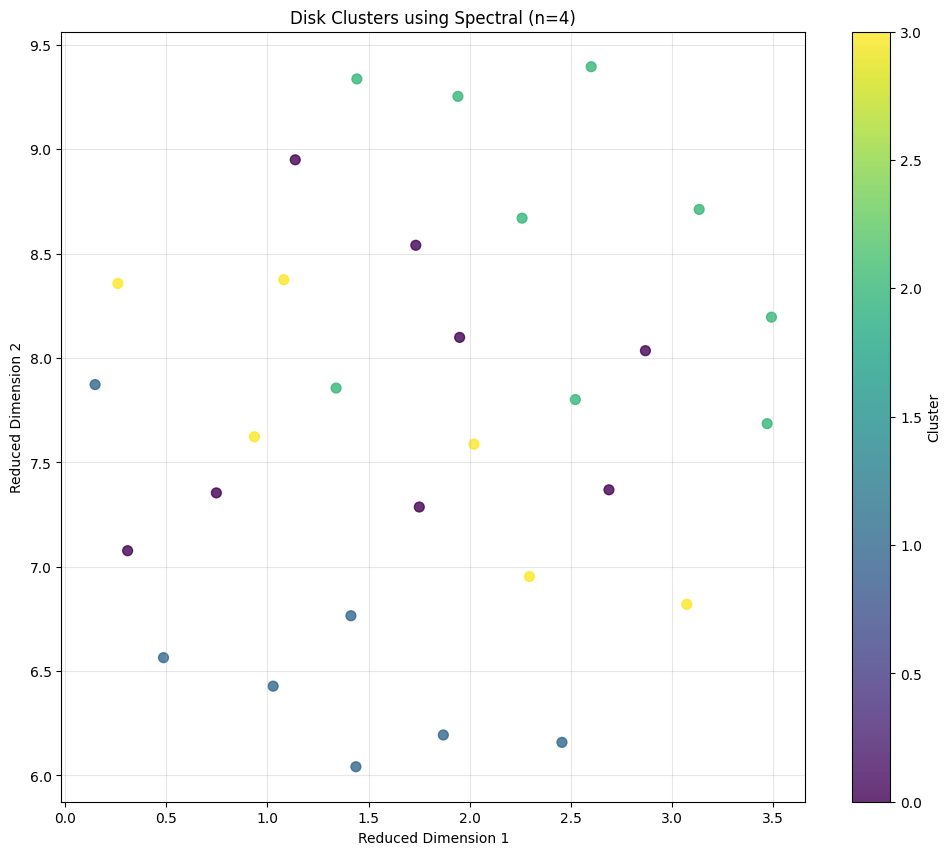

In [17]:
analyzer.visualize_clusters()

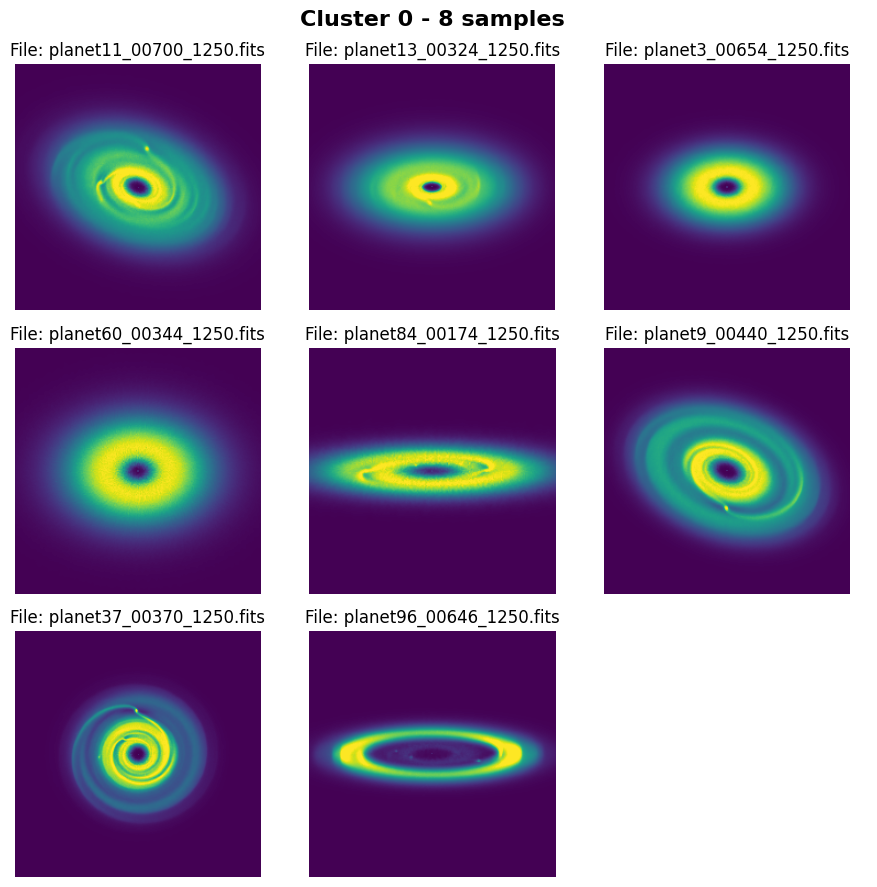

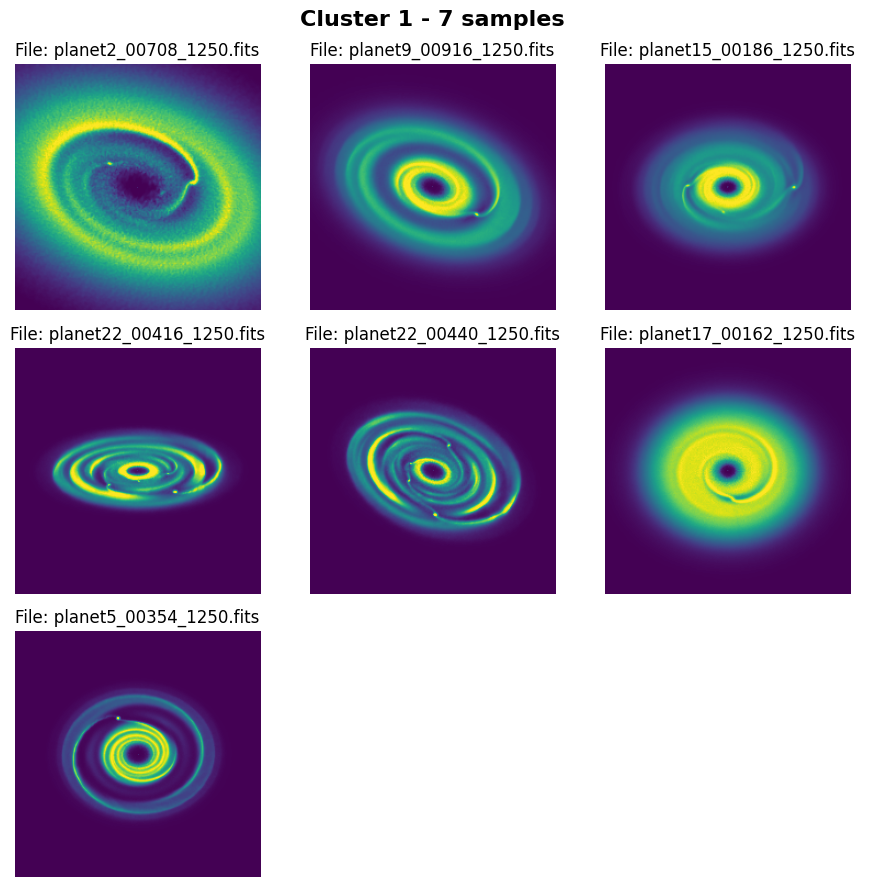

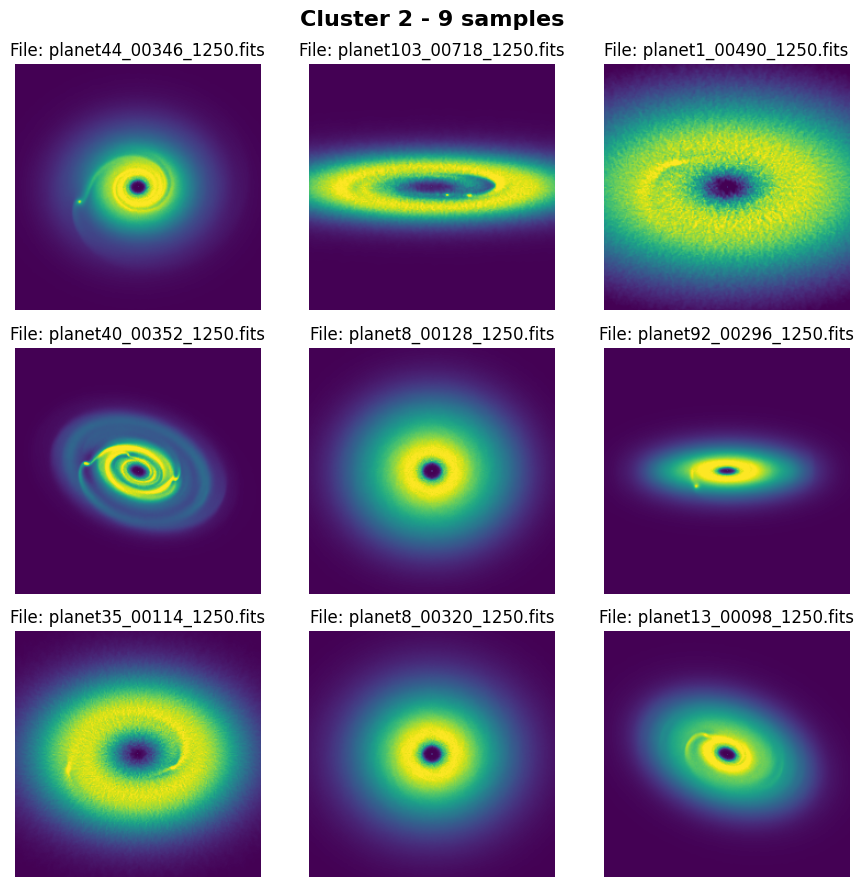

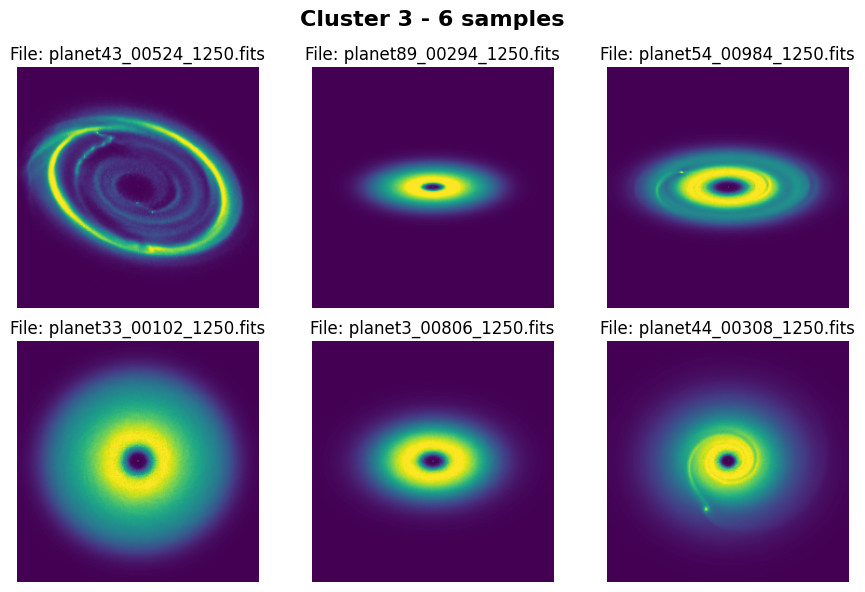

In [18]:
analyzer.plot_cluster()

# Visualizing Conv-MAE latent space

In [19]:
model = ConvMaskedAutoencoder()
save_dir = "./Conv_MAE_best.pth"
check_point = torch.load(save_dir)
model.load_state_dict(check_point['model_dict'])
analyzer = LatenSpaceAnalyzer(model, test_mae_loader, model_type='convmae')

In [20]:
temp = analyzer.generate_latent_space_representations()
temp = analyzer.reduce_dim()
temp = analyzer.cluster_images(method='spectral', n_clusters=4)

  0%|          | 0/1 [00:00<?, ?it/s]

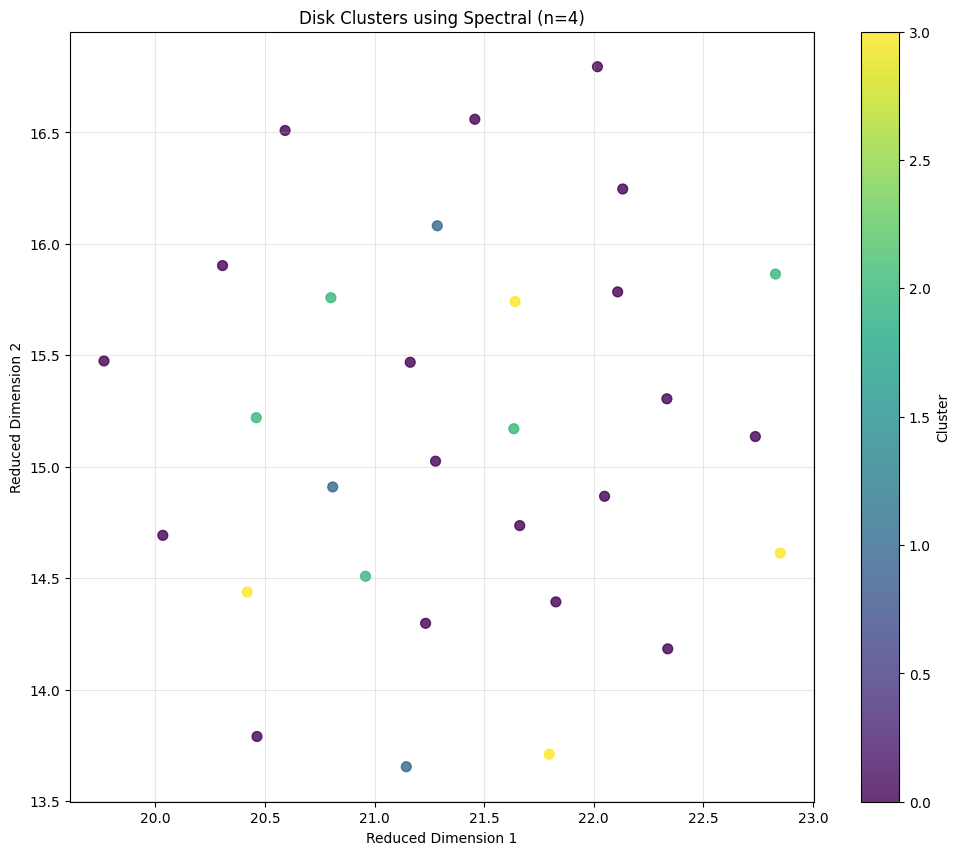

In [21]:
analyzer.visualize_clusters()

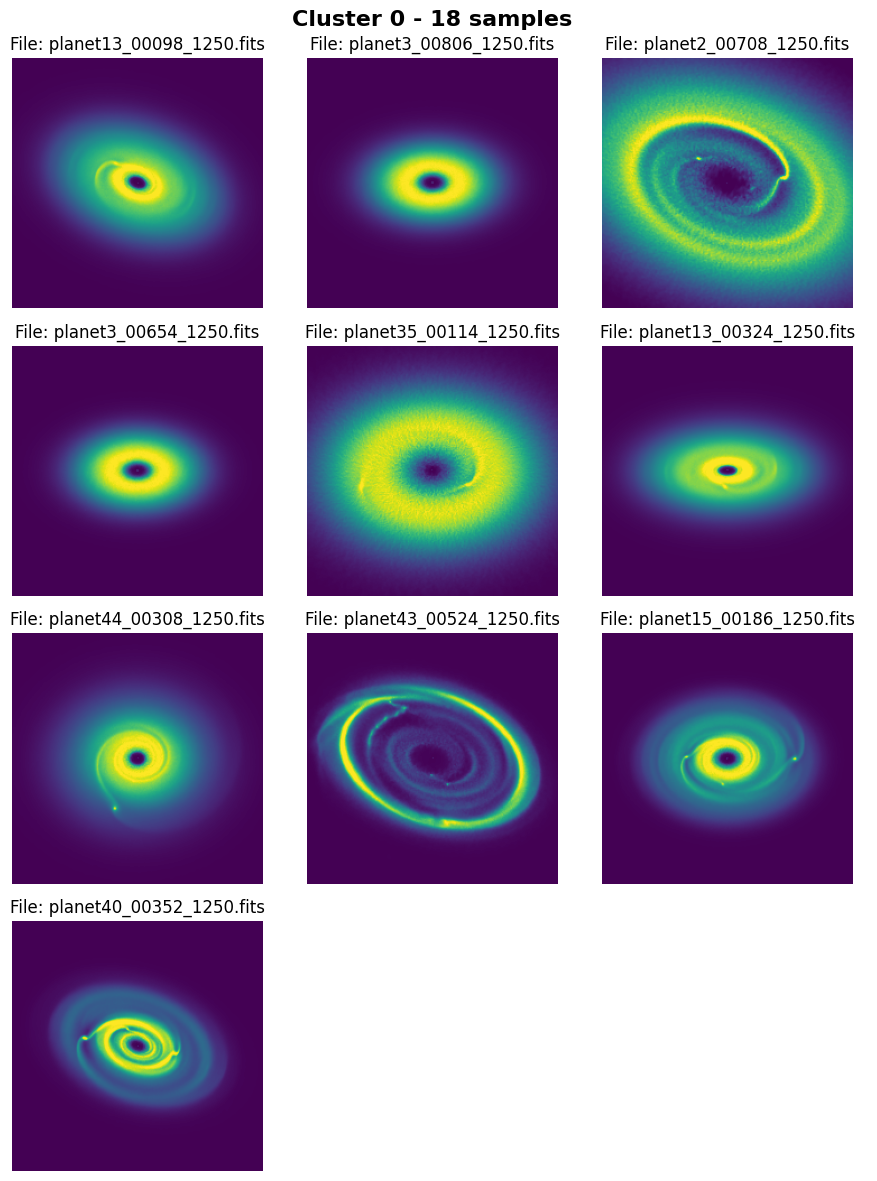

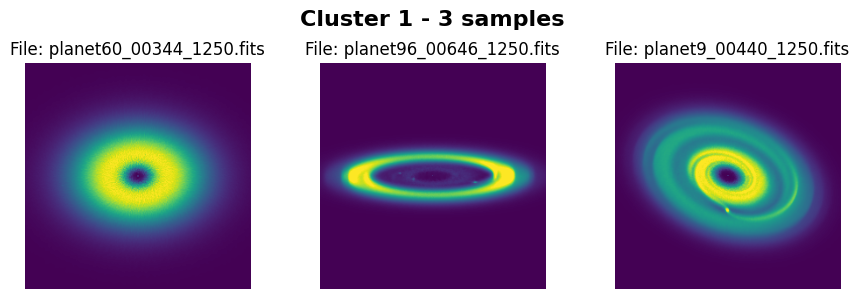

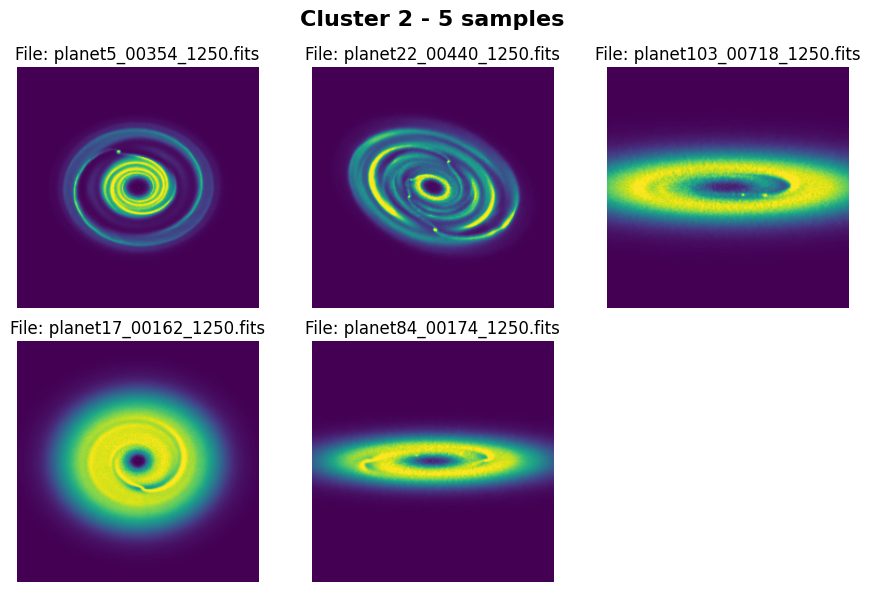

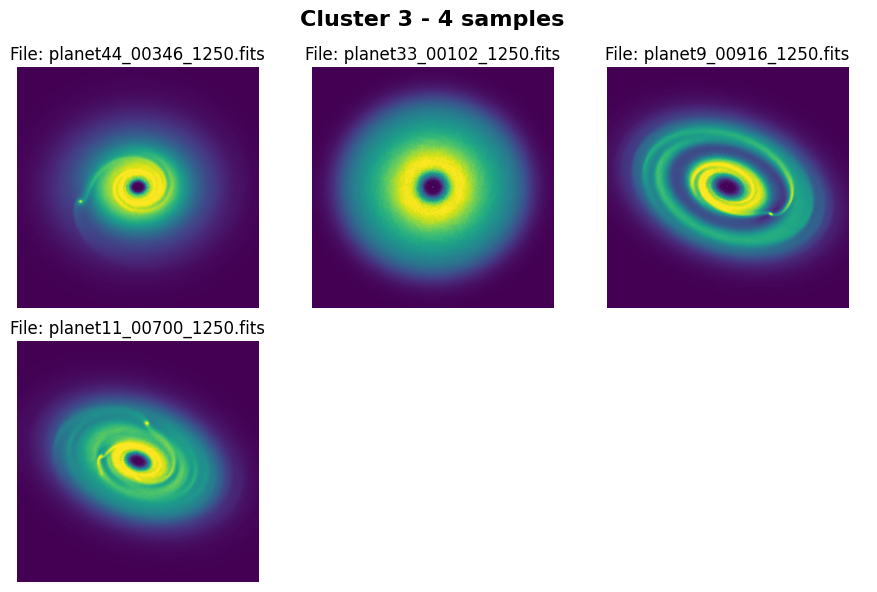

In [22]:
analyzer.plot_cluster()

# Visualizing Custom Autoencoder latent space

In [23]:
model = CustomAutoencoder(input_dim = feats_dim)
save_dir = "./CustomAutoencoder_best.pth"
check_point = torch.load(save_dir)
model.load_state_dict(check_point['model_dict'])
analyzer = LatenSpaceAnalyzer(model, test_cae_loader, model_type='cae')

In [24]:
temp = analyzer.generate_latent_space_representations()
temp = analyzer.reduce_dim()
temp = analyzer.cluster_images(method='spectral', n_clusters=4)

  0%|          | 0/1 [00:00<?, ?it/s]

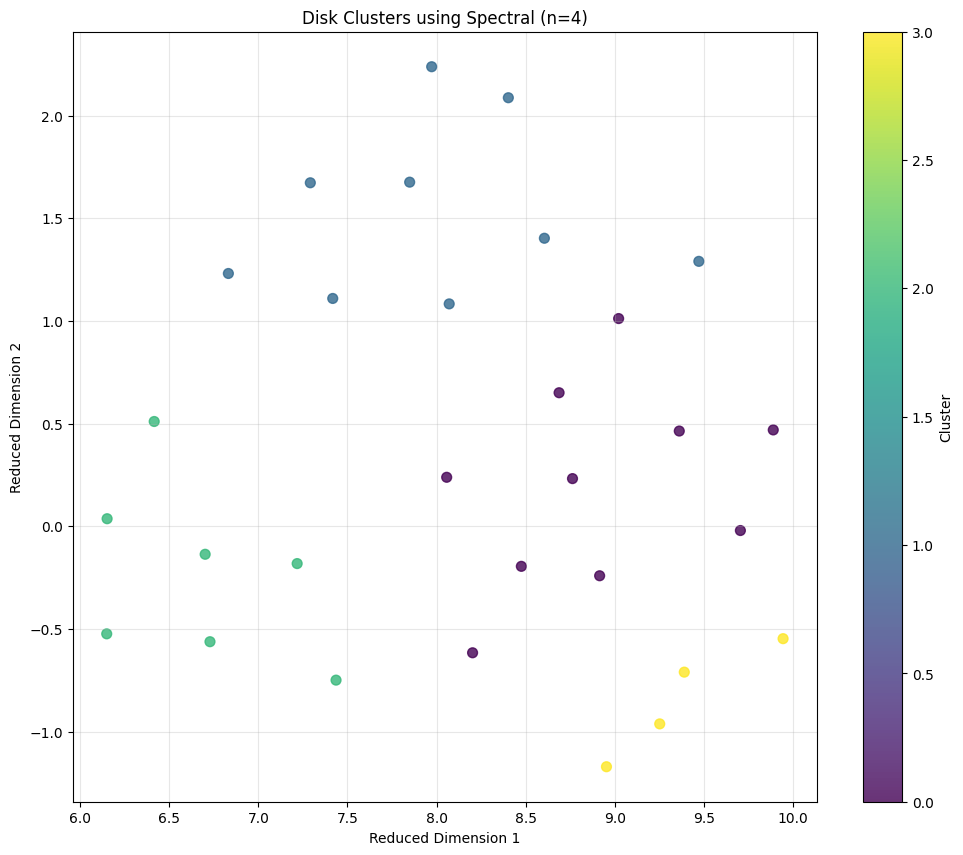

In [25]:
analyzer.visualize_clusters()

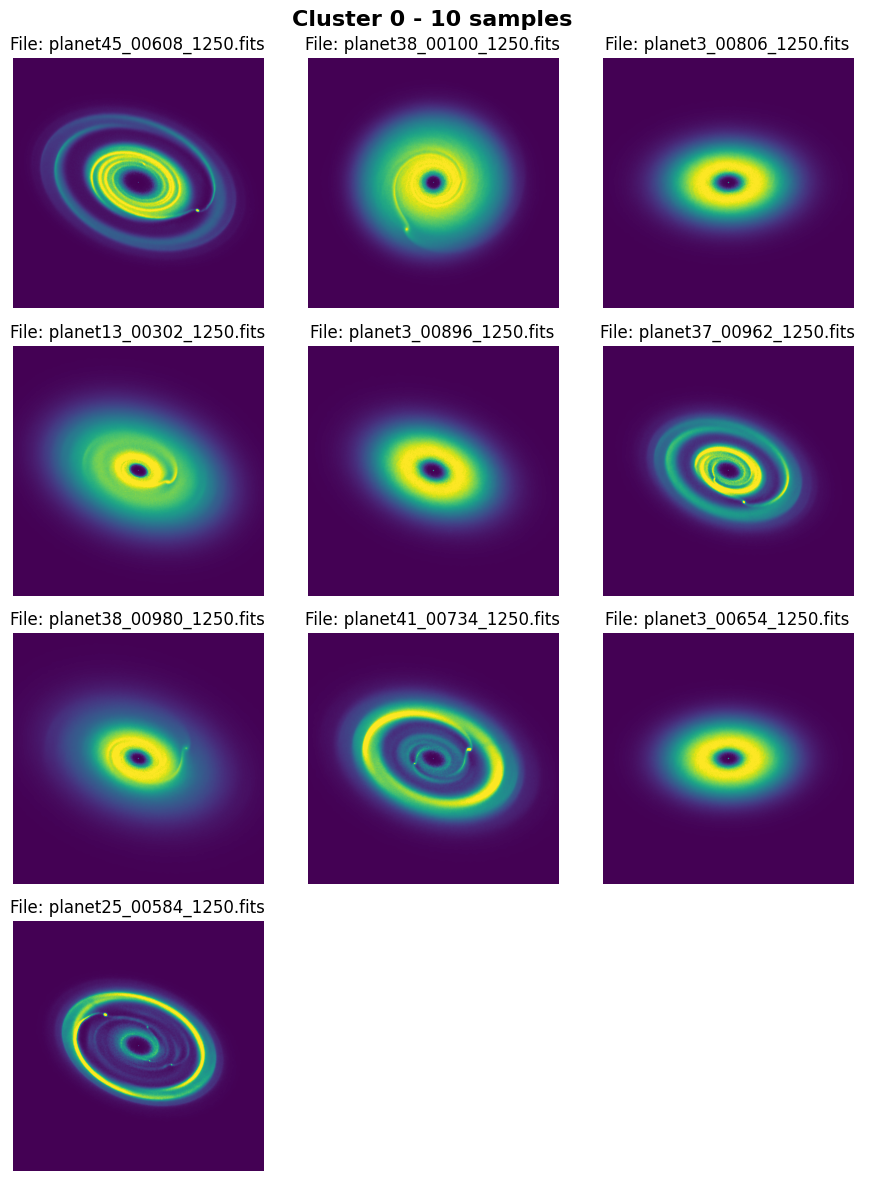

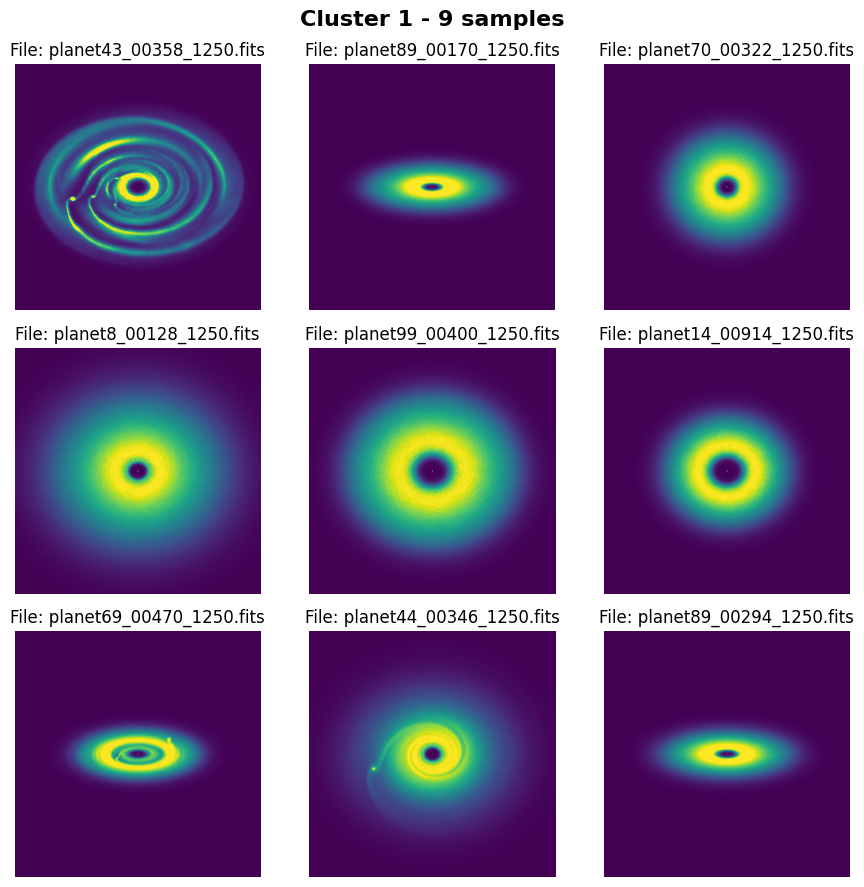

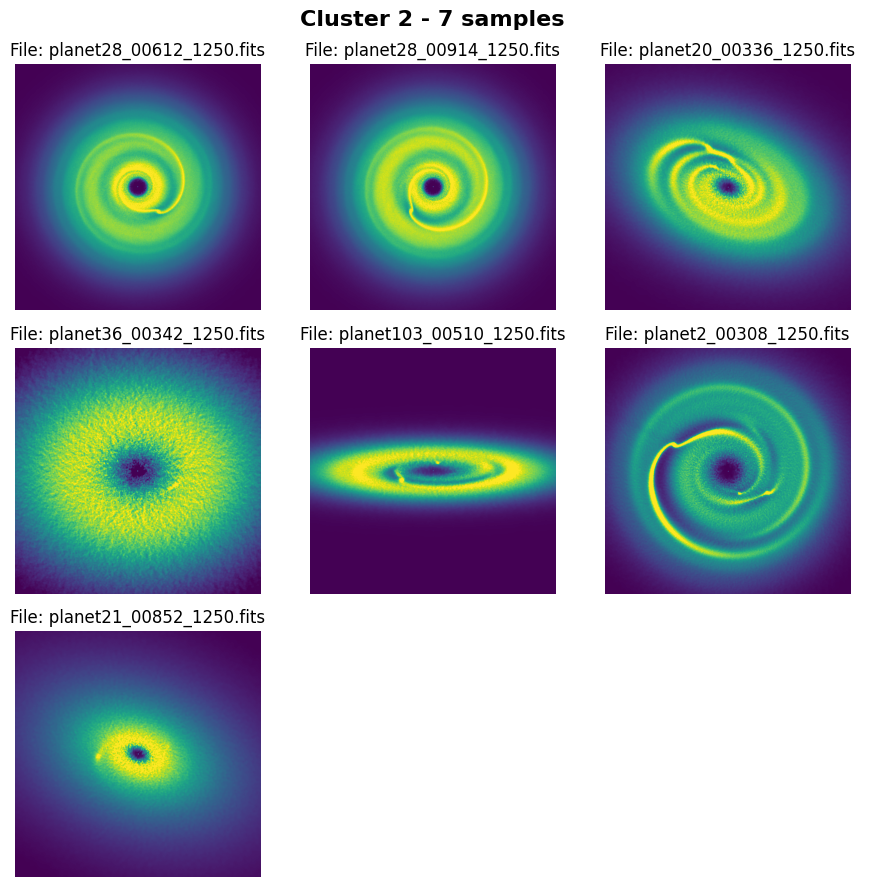

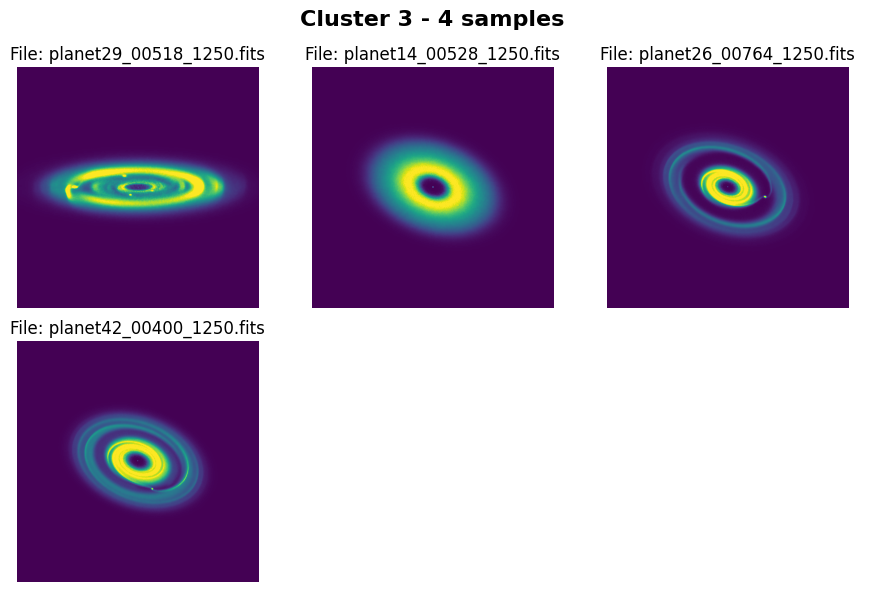

In [26]:
analyzer.plot_cluster()

# Final Comments and future works
- Clusters formed by all the models are highly differentiable while the ViT based being the most interpretable 
- Feature extraction from convolutions and hand crafted features also perform well
- I will leverage the ViT based MAE for the final project by first using knowledge distillation with ViT-large as teacher model to my ViT-base model
- Further pretraining of the latent space representations using Contrastive learning with losses like Sim-CLR, MoCo and DiNO will give use more effective representations

---

# Final results of all models

### 1. Masked autencoder (Transformer based):
- **MSE : $0.00076$** <br>
- **MS-SSIM : $0.93238$**

### 2. Convolutional Masked Autoencoder:
- **MSE : $2.65 \times 10^{-6}$**
- **MS-SSIM : $0.99855$**

### 3. Custom Autoencoder:
- **MSE : $0.27384$**
- **MS-SSIM : $0.96518$**
